Download the MNIST Dataset
---

In [1]:
from sklearn.datasets import fetch_mldata
raw = fetch_mldata("MNIST original")
raw

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

Explore the Dataset
---

In [2]:
mnist = raw["data"]
mnist_labels = raw["target"]

In [3]:
mnist.shape, mnist_labels.shape

((70000, 784), (70000,))

Plot An Example Image
---

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

5.0


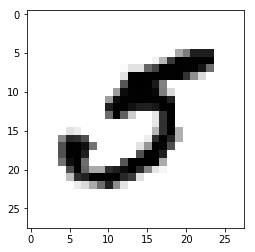

In [5]:
some_digit_image = mnist[36000].reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
print(mnist_labels[36000])

Split Into Training and Testing
---

- MNIST is already split up. First 60K are training

In [6]:
mnist_train = mnist[:60000]
mnist_labels_train = mnist_labels[:60000]

mnist_test = mnist[60000:]
mnist_labels_test = mnist_labels[60000:]

Shuffle the Training Set
---

Sometimes ordering can throw off ML algorithms

In [7]:
import numpy as np

In [8]:
shuffle_indices = np.random.permutation(60000)
mnist_train = mnist_train[shuffle_indices]
mnist_labels_train = mnist_labels_train[shuffle_indices]

A Simple Binary Classifier
---

Can we identify only 5's?

In [9]:
mnist_labels_train_5 = (mnist_labels_train == 5.)
mnist_labels_test_5 = (mnist_labels_test == 5.)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(mnist_train, mnist_labels_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [11]:
sgd_clf.predict([mnist[36000]])

array([ True], dtype=bool)

Evaluating Performance
---

- Cross Validation, by hand then using the cross_val_score function from sklearn

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(mnist_train, mnist_labels_train_5):
    # Clone the Model
    clone_clf = clone(sgd_clf)
    
    # Get the Stratified Train and Test Sets
    mnist_train_folds = mnist_train[train_index]
    mnist_labels_train_folds = (mnist_labels_train_5[train_index])
    mnist_test_folds = mnist_train[test_index]
    mnist_labels_test_folds = (mnist_labels_train_5[test_index])
    
    # Fit the stratified training set
    clone_clf.fit(mnist_train_folds, mnist_labels_train_folds)
    
    # Make the prediction on the test set
    mnist_labels_predict = clone_clf.predict(mnist_test_folds)
    num_correct = sum(mnist_labels_predict == mnist_labels_test_folds)
    print(num_correct / len(mnist_labels_test_folds))

0.96355
0.9668
0.95605


In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, mnist_train, mnist_labels_train_5, cv=3, scoring="accuracy")

array([ 0.96355,  0.9668 ,  0.95605])

Accuracy Can Be Terrible for Classification
---

Look at the *Confusion Matrix*

```python
array([[true_negatives, false_positives],
       [false_negatives, true_positives]])
```

In [14]:
from sklearn.model_selection import cross_val_predict

prediction = cross_val_predict(sgd_clf, mnist_train, mnist_labels_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(mnist_labels_train_5, prediction)

array([[53232,  1347],
       [  925,  4496]])

Concrete Metrics
---

1. `precision_score`: models gets the right answer percentage
2. `recall_score`: model detects the true classifier

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(mnist_labels_train_5, prediction), recall_score(mnist_labels_train_5, prediction)

(0.76946773917508127, 0.82936727541044086)

In [17]:
from sklearn.metrics import f1_score

f1_score(mnist_labels_train_5, prediction)

0.79829545454545459

Thresholds for `decision_function`
---

Balancing the precision and recall might be important in the application.

- Precision and Recall Plots

In [18]:
labels_scores = cross_val_predict(sgd_clf, mnist_train, mnist_labels_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(mnist_labels_train_5, labels_scores)

(0, 1)

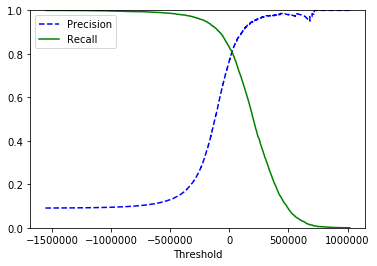

In [20]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])

- *receiver operating characteristic* (ROC) curves

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(mnist_labels_train_5, labels_scores)

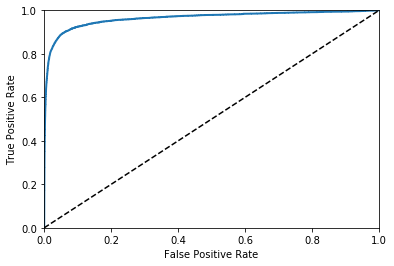

In [22]:
plt.plot(fpr, tpr, linewidth=2, label="ROC")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

- Integrate under the ROC curve. Purely random is 0.5, perfect is 1.0 `roc_auc_score` (Area Under Curve)

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(mnist_labels_train_5, labels_scores)

0.9638348186018707

Try a RandomForestClassifier
---

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

mnist_labels_probas_forest = cross_val_predict(forest_clf, mnist_train, mnist_labels_train_5, cv=3, method="predict_proba")

In [29]:
labels_scores_forest = mnist_labels_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(mnist_labels_train_5, labels_scores_forest)
roc_auc_score(mnist_labels_train_5, labels_scores_forest)

0.99297719902628823

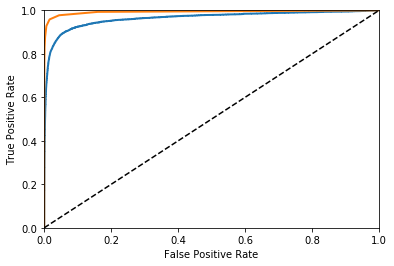

In [27]:
plt.plot(fpr, tpr, linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Binary Classification of 5's
---

- RandomForestClassifier better than SGDClassifier in this case